<a href="https://colab.research.google.com/github/ChardyBalla/Chardy/blob/main/RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFM Analysis with Python

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this notebook, we aim to learn the following:
1. Perform data exploration for a given dataset
2. Generate frequency, recency, and monetary (RFM) scores for customers
3. Create customer segments based on RFM scores

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In this exercise, we will use the same [online retail](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) dataset from the previous lesson (Cohort Analysis).

The dataset contains transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

We are tasked to create customer segments based on purchase patterns and to provide insights and personalized recommendations for each segment.

## Load and clean the data

Our data contains the following columns:

1. **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'C', it indicates a cancellation.
2. **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
3. **Description**: Product (item) name. Nominal.
4. **Quantity**: The quantities of each product (item) per transaction. Numeric.
5. **InvoiceDate**: Invoice date and time. Numeric. The day and time when a transaction was generated.
6. **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
7. **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
8. **Country**: Country name. Nominal. The name of the country where a customer resides.

Since we are using the same dataset from the previous lesson, we can utilize the same data loading and cleaning procedure we implemented. Recall that we had the following considerations for our data cleaning:

1. Remove transaction if its `InvoiceNo` starts with the letter `'C'` (indicates a cancellation)
2. Remove transaction if the `CustomerID` is null/blank. The transaction will not be useful for our analysis since there is no corresponding customer.
3. Check for outliers (e.g. `Quantity` and `UnitPrice` should not be negative)

Let's apply the same code from before

In [41]:
# We set Invoice and Customer ID as string types since they are the keys/ID for our dataset.
df = pd.read_excel('/content/drive/MyDrive/Refocus Module/Jupyter Notebook-20230501T012835Z-001/Jupyter Notebook/datasets/online_retail.xlsx',
                   dtype={'Invoice':str,
                          'InvoiceDate':'datetime64[ns]',
                          'Customer ID':str})
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


Let's first analyze the counts of transactions in our dataset

In [42]:
print('There are ', len(df), ' transactions in our dataset')
df.count()

There are  525461  transactions in our dataset


Invoice        525461
StockCode      525461
Description    522533
Quantity       525461
InvoiceDate    525461
Price          525461
Customer ID    417534
Country        525461
dtype: int64

We see that there are 525,461 transactions (rows) but some columns have lower counts. This indicates that there are null (empty) values for that column.

Let's count the `cancelled (starts with 'C')` invoices.

In [43]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [44]:
df['Invoice'].str.startswith('C')

0         False
1         False
2         False
3         False
4         False
          ...  
525456    False
525457    False
525458    False
525459    False
525460    False
Name: Invoice, Length: 525461, dtype: bool

In [45]:
~df['Invoice'].str.startswith('C')

0         True
1         True
2         True
3         True
4         True
          ... 
525456    True
525457    True
525458    True
525459    True
525460    True
Name: Invoice, Length: 525461, dtype: bool

In [46]:
df['Invoice'].str.startswith('C').sum()

10206

In [47]:
df = df[~df['Invoice'].str.startswith('C')]
df.count()

Invoice        515255
StockCode      515255
Description    512327
Quantity       515255
InvoiceDate    515255
Price          515255
Customer ID    407695
Country        515255
dtype: int64

We have 10,206 cancelled invoices in our dataset. We remove these transactions then proceed with removing the null/empty customer ID.

In [48]:
df['Customer ID'].isna().sum()

107560

In [49]:
df = df.dropna(subset=['Customer ID'])
df.count()

Invoice        407695
StockCode      407695
Description    407695
Quantity       407695
InvoiceDate    407695
Price          407695
Customer ID    407695
Country        407695
dtype: int64

We see that there are 107,560 transactions without a customer ID. This leaves us with 407,695 transactions.

Next, we check our `Quantity` and `Price` for outliers.

In [50]:
df[['Quantity', 'Price']].describe()

,Quantity,Price
count,407695.000000,407695.000000
mean,13.586686,3.294188
std,96.842229,34.756655
min,1.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,19152.000000,10953.500000


Using the describe function, we see some descriptive statistics for our variables. Notice that there are also large max quantities and price compared to their 75th percentiles. We can also choose to remove them, but since we have mostly wholesale customers, there is a good chance that these quantities are correct.

In [51]:
df[df['Quantity']==df['Quantity'].max()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
90857,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,2010-02-15 11:57:00,0.1,13902,Denmark


In [52]:
df[df['Price']==df['Price'].max()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
135013,502263,M,Manual,1,2010-03-23 15:22:00,10953.5,12918,United Kingdom


The transaction with a very large quantity is a mug with a price of 0.1. This seems plausible an we can choose to retain this. Similarly, the transaction with the very large price was manually generated (based on the description) and is only 1 quantity. We can also retain this.

We now have a clean dataset ready for our exploratory and RFM analysis.

## Exploratory Analysis

In the previous lesson, we were able to analyze the dataset and observe patterns based on the counts of unique invoice and customers, the total transactions per customer, and the monthly trend of transactions.

We can extend our previous exploratory analysis by looking at the following:

1. Distribution of Transactions per Customer (Frequency)
1. Distribution of Revenue per Customer (Monetary)
1. Total Monthly Revenue

Since we are now interested in the monetary aspect of the data, we add the related metrics in our analysis.

### Recall: Count of Invoice and Customers

In [53]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [54]:
df['Customer ID'].nunique()

4314

In [55]:
df['Invoice'].nunique()

19215

Recall that we have 19,215 unique transactions across 4,314 customers. This means that each invoice may have multiple stock codes (items).

### Recall: Number of Transactions per Customer

In [56]:
# group by Customer ID
# it may be possible to have multiple stock codes in a single invoice
# so we only count the unique Invoice.
df_customers = df.groupby('Customer ID')['Invoice'].nunique()
df_customers.head()

Customer ID
12346    11
12347     2
12348     1
12349     3
12351     1
Name: Invoice, dtype: int64

#### Who are the loyal customers (most transactions)?

Text(0.5, 0, 'Count of Transactions')

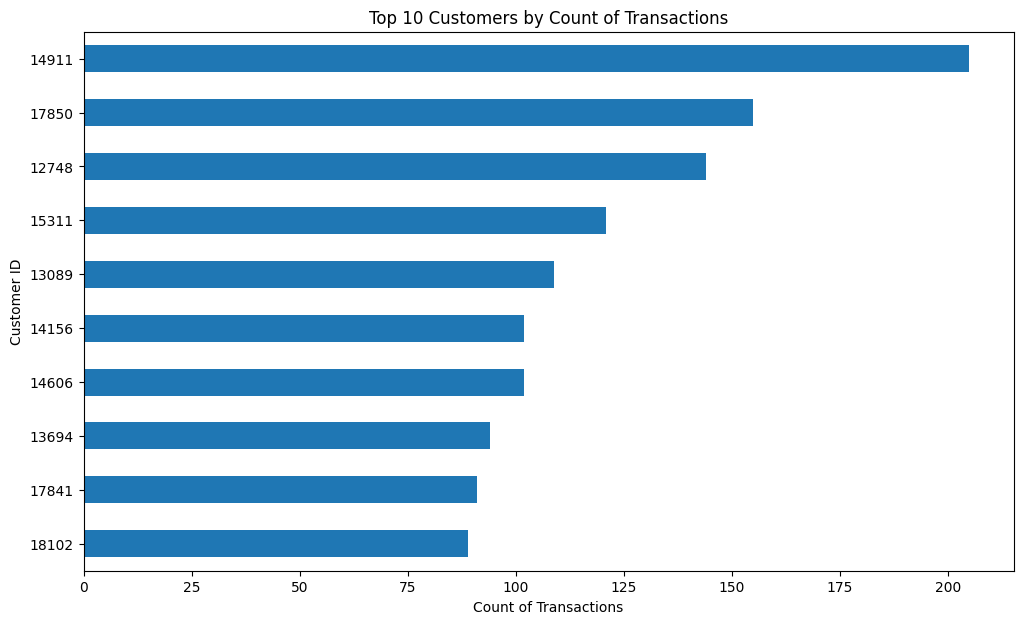

In [57]:
fig, ax = plt.subplots(figsize=(12, 7))
df_customers.sort_values(ascending=True).tail(10).plot(kind='barh', ax=ax)
ax.set_title('Top 10 Customers by Count of Transactions')
ax.set_xlabel('Count of Transactions')

From the plot above, we see that our top 10 customers have at least 80 transactions over the range of our dataset (01/12/2009 to 09/12/2011). Our top customer has more than 200 transactions!

#### What is the distribution of our customer transactions?

Text(0, 0.5, 'Count of Customers')

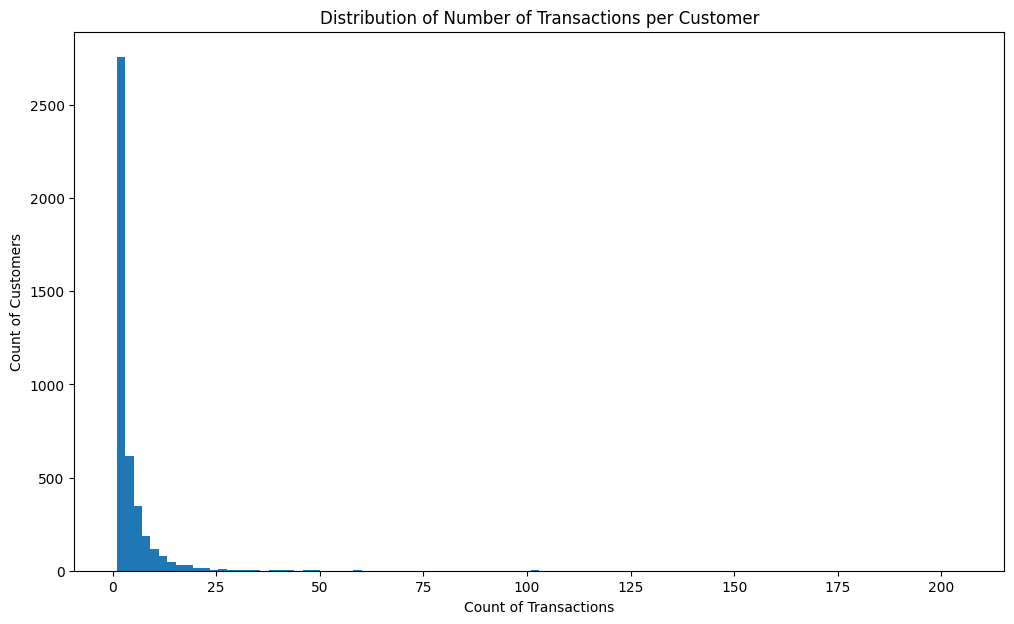

In [58]:
fig, ax = plt.subplots(figsize=(12, 7))
df_customers.plot(kind='hist', ax=ax, bins=100)
ax.set_title('Distribution of Number of Transactions per Customer')
ax.set_xlabel('Count of Transactions')
ax.set_ylabel('Count of Customers')

The histogram shows the distribution of our customer transactions. The leftmost bars indicate that we have a large number of customers (>2,500) with only a few transactions (least loyal). We also see some smaller bars in the right tail which tells us that we have a small number of customers with a large number of transactions (most loyal).

### Revenue per Customer

To get the total revenue per customer, we need to add a total amount column (quantity x unit price). We can then change our aggregate function to its' sum instead of the count of unique transactions.

In [59]:
# create a total_amount column
df['total_amount'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [60]:
# group by Customer ID
# get the sum of total_amount
df_customers = df.groupby('Customer ID')['total_amount'].sum()
df_customers.head()

Customer ID
12346     372.86
12347    1323.32
12348     222.16
12349    2671.14
12351     300.93
Name: total_amount, dtype: float64

#### Who are the top spenders?

Text(0.5, 0, 'Total Amount Spent')

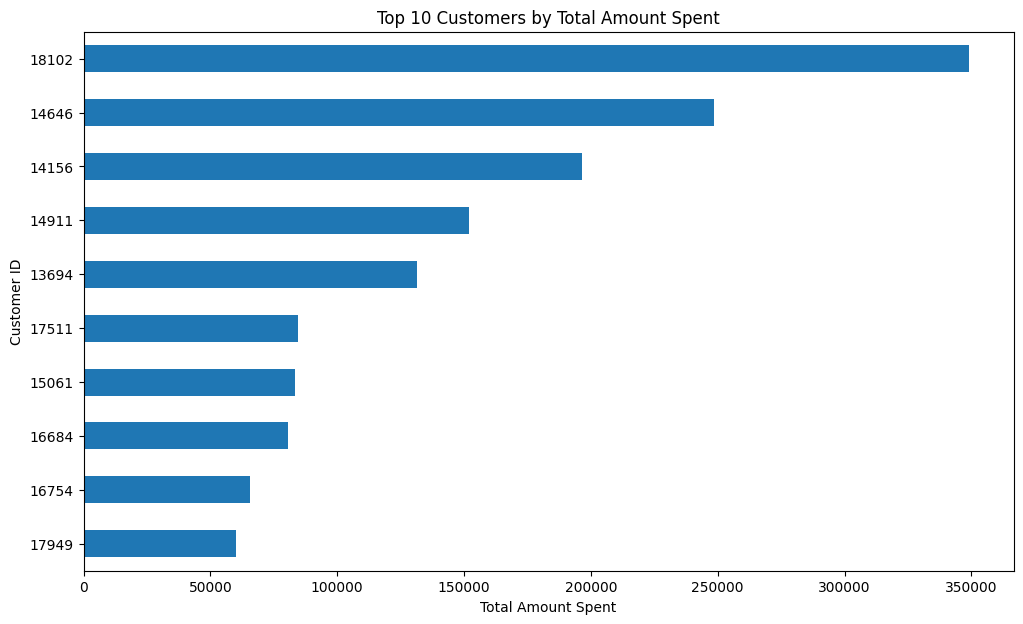

In [61]:
fig, ax = plt.subplots(figsize=(12, 7))
df_customers.sort_values(ascending=True).tail(10).plot(kind='barh', ax=ax)
ax.set_title('Top 10 Customers by Total Amount Spent')
ax.set_xlabel('Total Amount Spent')

Notice that our top spenders are not necessarily the most loyal (customer 18102 is the top spender but only top 10 with the most number of transactions). There is also a large gap between the amount spent - could be because most customers are wholesalers.

#### What is the distribution of customer spending?

Text(0, 0.5, 'Count of Customers')

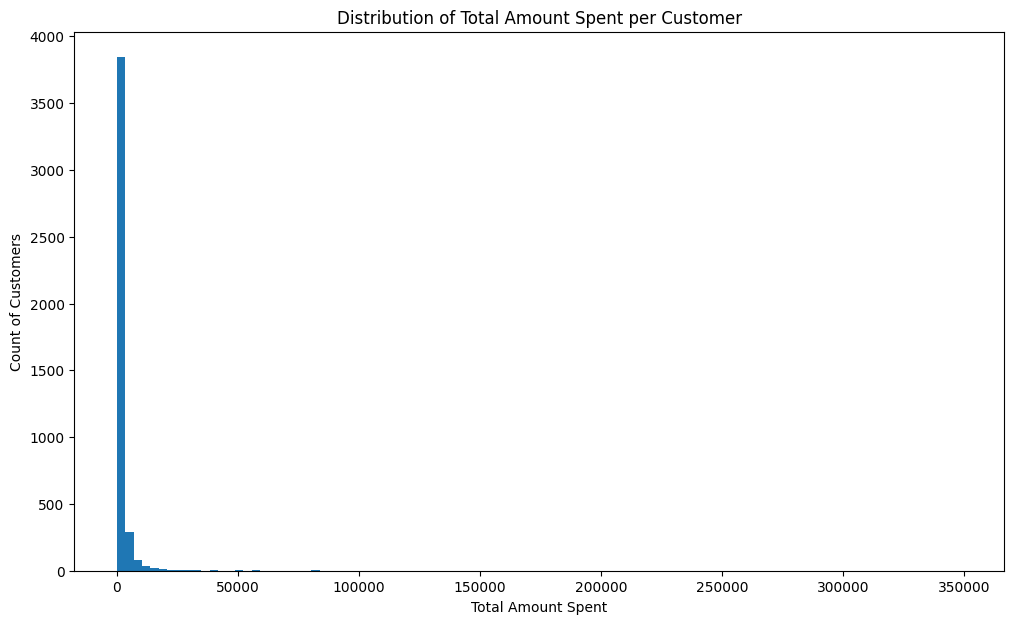

In [62]:
fig, ax = plt.subplots(figsize=(12, 7))
df_customers.plot(kind='hist', ax=ax, bins=100)
ax.set_title('Distribution of Total Amount Spent per Customer')
ax.set_xlabel('Total Amount Spent')
ax.set_ylabel('Count of Customers')

Similarly, the distribution of total amount spent is also skewed towards the lower range. The leftmost bars indicate that we have a large number of customers (>3,500) with small spending (<50,000). We also see some smaller bars in the right tail which tells us that we have a small number of customers with large spending (>50,000).

### Monthly Revenue

In [63]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

In [64]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_amount,Year,Month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2009,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2009,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2009,12


In [65]:
df_monthly = df.groupby(['Year', 'Month'])['total_amount'].sum()
df_monthly

Year  Month
2009  12        686654.160
2010  1         557319.062
      2         506371.066
      3         699608.991
      4         594609.192
      5         599985.790
      6         639066.580
      7         591636.740
      8         604242.650
      9         831615.001
      10       1036680.000
      11       1172336.042
      12        311878.000
Name: total_amount, dtype: float64

Text(0, 0.5, 'Total Revenue')

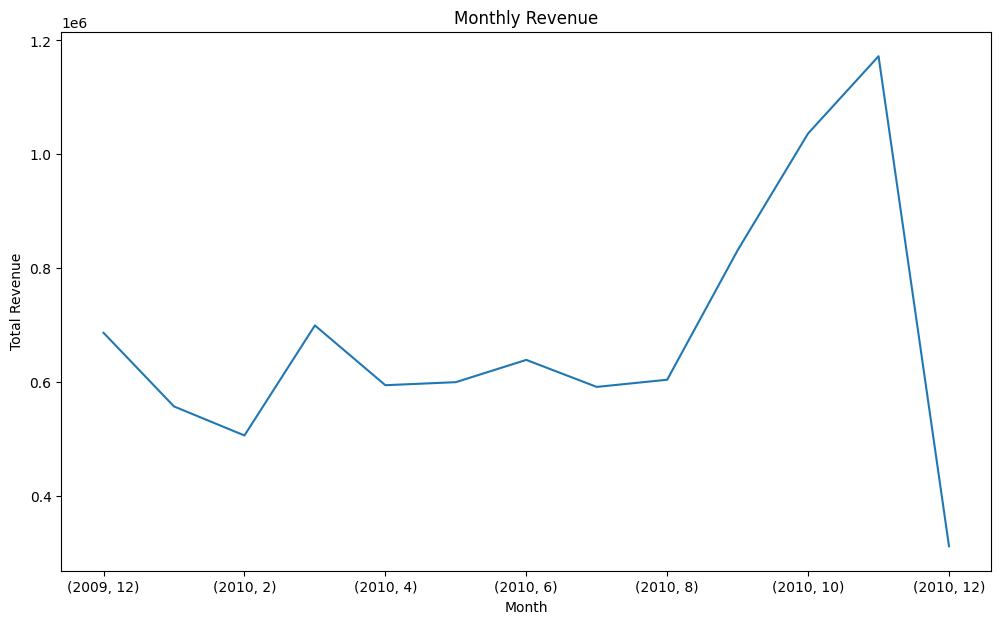

In [66]:
fig, ax = plt.subplots(figsize=(12, 7))
df_monthly.plot(ax=ax)
ax.set_title('Monthly Revenue')
ax.set_xlabel('Month')
ax.set_ylabel('Total Revenue')

Looking at the monthly revenue, observe that we now have a larger increase towards the end of the year. This supports our previous observation that some customers are seasonal and they would tend to purchase towards the end of the year (Christmas season).

## RFM Analysis

We can now proceed with the RFM Analysis.

In this case, we need to set a "current date" for our recency calculations. Let's assume that our current date is 1 day after the latest in our dataset. In actual application, we can use the actual current date as long as the dataset is also updated.

Let's define the current date. To work with dates in python, we need to import the [datetime](https://docs.python.org/3/library/datetime.html) module. It has a timedelta function which is used to add or subtract different time intervals (days, weeks, months, etc.)

In [67]:
import datetime

latest_invoice_date = df['InvoiceDate'].max()
current_date = latest_invoice_date + datetime.timedelta(days=1)
latest_invoice_date, current_date

(Timestamp('2010-12-09 20:01:00'), Timestamp('2010-12-10 20:01:00'))

Our latest invoice date is on December 9, 2010. We set our current date to December 10, 2010. We can now proceed to calculate our recency, frequency, and monetary values.

In [68]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_amount,Year,Month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2009,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2009,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2009,12


### Recency

We define our `recency` to be the number of days since a customer's latest transaction. To get this value, we get the latest invoice date (max) of each customer and get the number of days to the current date.

In [69]:
# get max invoice date per customer
df_latest_invoice = df.groupby('Customer ID')['InvoiceDate'].max()
df_latest_invoice.head()

Customer ID
12346   2010-06-28 13:53:00
12347   2010-12-07 14:57:00
12348   2010-09-27 14:59:00
12349   2010-10-28 08:23:00
12351   2010-11-29 15:23:00
Name: InvoiceDate, dtype: datetime64[ns]

In [70]:
# get number of days between latest invoice date and current date
# .dt.days means that we only get the actual days (not decimal)
df_recency = (current_date - df_latest_invoice).dt.days
df_recency.head()

Customer ID
12346    165
12347      3
12348     74
12349     43
12351     11
Name: InvoiceDate, dtype: int64

In the resulting table, we see that customer 12346 had their latest transaction on June 28, 2010. Since our current date is December 10, 2010, it has been 165 days already since their last purchase.

Customer 12347, on the other hand, had a transaction just 3 days ago!

### Frequency

We now calculate our `frequency`. This is defined by the number of transactions per customer over the whole period of our dataset. To calculate this, we use the groupby functions we used in our exploratory analysis.

In [71]:
df_frequency = df.groupby('Customer ID')['Invoice'].nunique()
df_frequency

Customer ID
12346    11
12347     2
12348     1
12349     3
12351     1
         ..
18283     6
18284     1
18285     1
18286     2
18287     4
Name: Invoice, Length: 4314, dtype: int64

This table tells us how many transactions our customers had from December 2009 - December 2010.

### Monetary
Lastly, we calculate our `monetary` values with the same groupby function. We define this metric by the total amount spent by each customer.

In [72]:
df_monetary = df.groupby('Customer ID')['total_amount'].sum()
df_monetary.head()

Customer ID
12346     372.86
12347    1323.32
12348     222.16
12349    2671.14
12351     300.93
Name: total_amount, dtype: float64

### RFM Scores

We now merge these tables into a single dataframe. We put each series together in a dictionary and use `pd.DataFrame`

In [73]:
df_rfm = pd.DataFrame({'recency':df_recency, 'frequency':df_frequency, 'monetary':df_monetary})
df_rfm.head(10)

,recency,frequency,monetary
Customer ID,,,
12346,165,11,372.86
12347,3,2,1323.32
12348,74,1,222.16
12349,43,3,2671.14
12351,11,1,300.93
12352,11,2,343.80
12353,44,1,317.76
12355,203,1,488.21
12356,16,3,3562.25


We now have RFM values for each customer. A common way to generate the RFM scores is to group each customer by the quantile that they belong to. For example, we can define top spenders to be those in the 75th quantile and up in terms of monetary value.

In [74]:
quantiles = df_rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles

,recency,frequency,monetary
0.25,18.0,1.0,307.9500
0.50,53.0,2.0,705.5500
0.75,136.0,5.0,1722.8025


Using the quantiles function, we can get our thresholds for segmentation.

1. For recency score (lower is better):
- Score = 1; quantile between 0-0.25
- Score = 2; quantile between 0.25-0.5
- Score = 3; quantile between 0.5-0.75
- Score = 4; quantile between 0.75 - 1

<br>
2. For frequency and monetary score (higher is better):
- Score = 1; quantile between 0.75 - 1
- Score = 2; quantile between 0.5-0.75
- Score = 3; quantile between 0.25-0.5
- Score = 4; quantile between 0-0.25

<br>

Let's use this guide for our analysis:

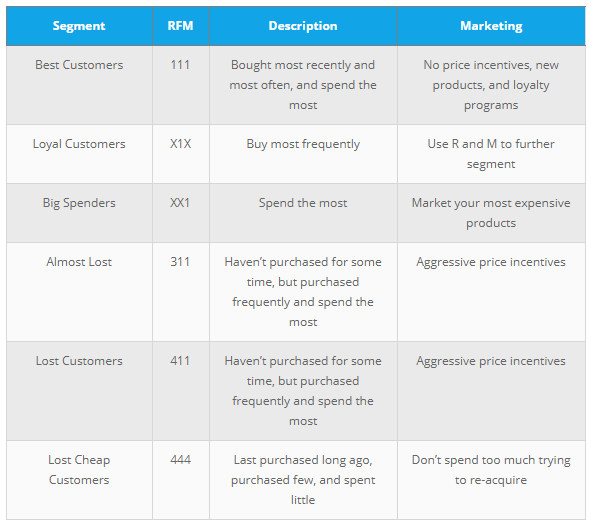

We calculate the RFM scores based on their quantiles.

#### Recency Score

In [77]:
# create a dictionary with the recency quantiles
recency_dict = quantiles['recency'].to_dict()
recency_dict

{0.25: 18.0, 0.5: 53.0, 0.75: 136.0}

In [78]:
# create a function to calculate recency score
def recency_score(recency, recency_dict):
    if recency <= recency_dict[0.25]:
        # recency_score = 1 if recency is between 0-0.25 quantile
        return '1'
    elif recency <= recency_dict[0.5]:
        # recency_score = 2 if recency is between 0.25-0.5 quantile
        return '2'
    elif recency <= recency_dict[0.75]:
        # recency_score = 3 if recency is between 0.5-0.75 quantile
        return '3'
    else:
        # recency_score = 4 if recency is between 0.75-1 quantile
        return '4'

df_rfm['recency_score'] = df_rfm['recency'].apply(recency_score, args=(recency_dict,))
df_rfm.head()

,recency,frequency,monetary,recency_score
Customer ID,,,,
12346,165,11,372.86,4
12347,3,2,1323.32,1
12348,74,1,222.16,3
12349,43,3,2671.14,2
12351,11,1,300.93,1


### Frequency Score

In [79]:
# create a dictionary with the frequency quantiles
frequency_dict = quantiles['frequency'].to_dict()
frequency_dict

{0.25: 1.0, 0.5: 2.0, 0.75: 5.0}

In [80]:
# create a function to calculate frequency score
def frequency_score(frequency, frequency_dict):
    if frequency <= frequency_dict[0.25]:
        # frequency_score = 4 if frequency is between 0-0.25 quantile
        return '4'
    elif frequency <= frequency_dict[0.5]:
        # frequency_score = 3 if frequency is between 0.25-0.5 quantile
        return '3'
    elif frequency <= frequency_dict[0.75]:
        # frequency_score = 2 if frequency is between 0.5-0.75 quantile
        return '2'
    else:
        # frequency_score = 1 if frequency is between 0.75-1 quantile
        return '1'

df_rfm['frequency_score'] = df_rfm['frequency'].apply(frequency_score, args=(frequency_dict,))
df_rfm.head()

,recency,frequency,monetary,recency_score,frequency_score
Customer ID,,,,,
12346,165,11,372.86,4,1
12347,3,2,1323.32,1,3
12348,74,1,222.16,3,4
12349,43,3,2671.14,2,2
12351,11,1,300.93,1,4


### Monetary Score

In [81]:
# create a dictionary with the monetary quantiles
monetary_dict = quantiles['monetary'].to_dict()
monetary_dict

{0.25: 307.95, 0.5: 705.55, 0.75: 1722.8025}

In [82]:
# create a function to calculate monetary score
def monetary_score(monetary, monetary_dict):
    if monetary <= monetary_dict[0.25]:
        # monetary_score = 4 if monetary is between 0-0.25 quantile
        return '4'
    elif monetary <= monetary_dict[0.5]:
        # monetary_score = 3 if monetary is between 0.25-0.5 quantile
        return '3'
    elif monetary <= monetary_dict[0.75]:
        # monetary_score = 2 if monetary is between 0.5-0.75 quantile
        return '2'
    else:
        # monetary_score = 1 if monetary is between 0.75-1 quantile
        return '1'

df_rfm['monetary_score'] = df_rfm['monetary'].apply(monetary_score, args=(monetary_dict,))
df_rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score
Customer ID,,,,,,
12346,165,11,372.86,4,1,3
12347,3,2,1323.32,1,3,2
12348,74,1,222.16,3,4,4
12349,43,3,2671.14,2,2,1
12351,11,1,300.93,1,4,4


#### Concatenate the RFM Scores

In [83]:
df_rfm['rfm_score'] = df_rfm['recency_score'] + df_rfm['frequency_score'] + df_rfm['monetary_score']
df_rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
Customer ID,,,,,,,
12346,165,11,372.86,4,1,3,413
12347,3,2,1323.32,1,3,2,132
12348,74,1,222.16,3,4,4,344
12349,43,3,2671.14,2,2,1,221
12351,11,1,300.93,1,4,4,144
12352,11,2,343.80,1,3,3,133
12353,44,1,317.76,2,4,3,243
12355,203,1,488.21,4,4,3,443
12356,16,3,3562.25,1,2,1,121


The resulting table shows corresponding RFM scores for each customer. We can now analyze each segment and create personalized recommendations for each customer.

## RFM Results

Recall our RFM score segmentation:

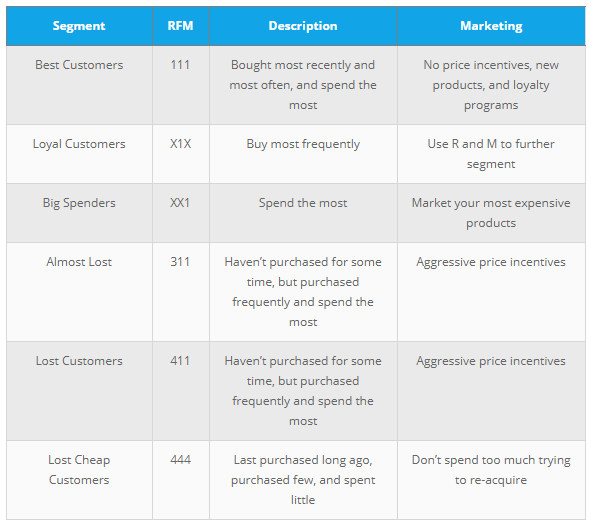

### How many customers do we have in each segment?

To get the counts of customers for each segment, we use the filtering techniques we learned from pandas.

In [84]:
print("Best Customers")
len(df_rfm[df_rfm['rfm_score']=='111'])

Best Customers


441

In [85]:
# let's store the segment counts in a dictionary
segment_counts = {'best_customers (111)': len(df_rfm[df_rfm['rfm_score']=='111']),
                  'loyal_customers (X1X)': len(df_rfm[df_rfm['frequency_score']=='1']),
                  'big_spenders (XX1)': len(df_rfm[df_rfm['monetary_score']=='1']),
                  'almost_lost (311)': len(df_rfm[df_rfm['rfm_score']=='311']),
                  'lost_good_customers (411)': len(df_rfm[df_rfm['rfm_score']=='411']),
                  'lost_cheap_customers (444)': len(df_rfm[df_rfm['rfm_score']=='444'])}

In [86]:
# create a dataframe
df_counts = pd.DataFrame(segment_counts.values(), index=segment_counts.keys(), columns=['counts'])
df_counts

,counts
best_customers (111),441
loyal_customers (X1X),942
big_spenders (XX1),1079
almost_lost (311),98
lost_good_customers (411),16
lost_cheap_customers (444),463


Text(0, 0.5, '# Customers per Segment')

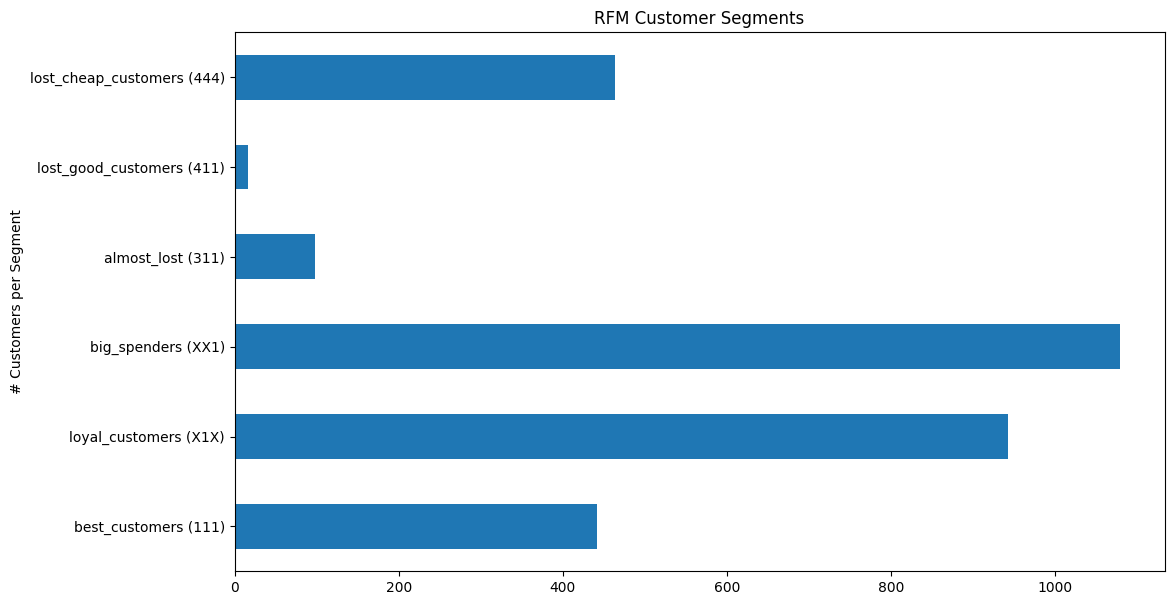

In [87]:
# plot the counts
fig, ax = plt.subplots(figsize=(12,7))
df_counts.plot(kind='barh', ax=ax, legend=False)
ax.set_title('RFM Customer Segments')
ax.set_ylabel('# Customers per Segment')

From the results, we can separate which customers are lost (no recent transactions) or which customers are consistently purchasing.

Note that the total counts of all these segments are not equal to the total counts of our customers. This is because we have some segments that are generic (big_spenders looking only at the monetary value, loyal_customers looking only at the frequency). Let's re-create the bar plot using the percentages to get a better picture of our customers.

In [88]:
# get percentages
customer_count = df['Customer ID'].nunique()

df_counts['pct'] = df_counts['counts']/customer_count
df_counts

,counts,pct
best_customers (111),441,0.102225
loyal_customers (X1X),942,0.218359
big_spenders (XX1),1079,0.250116
almost_lost (311),98,0.022717
lost_good_customers (411),16,0.003709
lost_cheap_customers (444),463,0.107325


Text(0.5, 0, '% Customers per Segment')

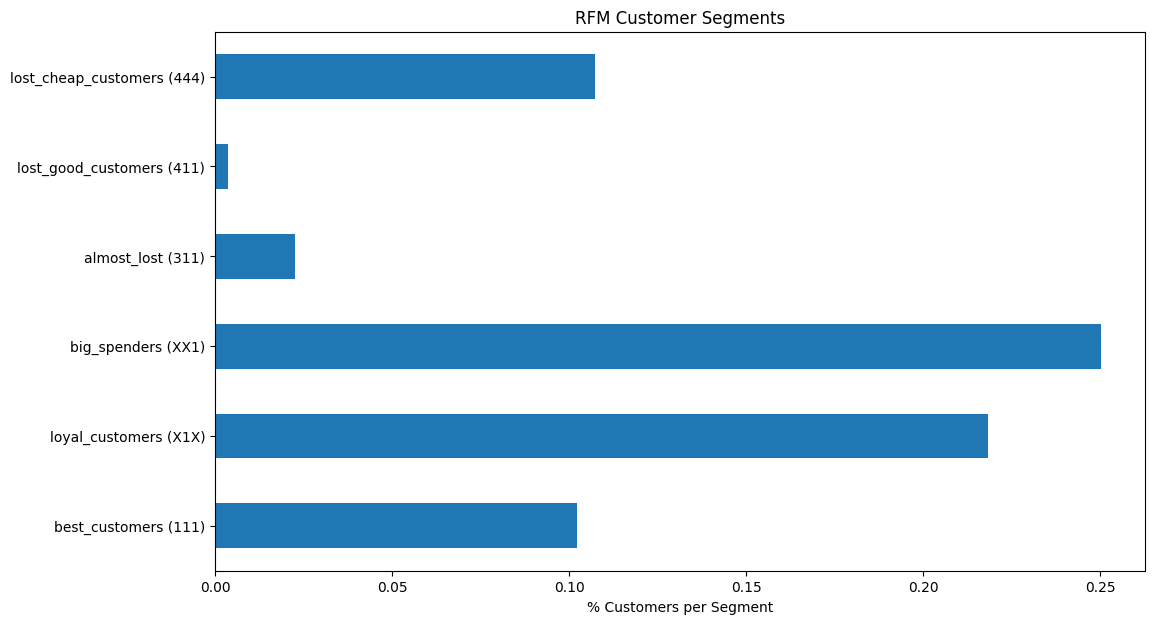

In [89]:
# plot the counts
fig, ax = plt.subplots(figsize=(12,7))
df_counts['pct'].plot(kind='barh', ax=ax, legend=False)
ax.set_title('RFM Customer Segments')
ax.set_xlabel('% Customers per Segment')

With these percentages, we see that around 11% of the customer base (lost_cheap_customers + lost_good_customers) are lost. Most of which are the infrequent and low value customers.

On the opposite end, our best customers (recent, high frequency, and high value) also takes 10% of the total.

### Who are our Top Customers?

The top customers are expected to fall in the 111 segment. We filter our table and sort them by monetary value.

In [90]:
df_rfm[df_rfm['rfm_score']=='111'].sort_values('monetary', ascending=False).head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
Customer ID,,,,,,,
18102,1,89,349164.35,1,1,1,111
14646,10,78,248396.50,1,1,1,111
14156,7,102,196566.74,1,1,1,111
14911,1,205,152147.57,1,1,1,111
13694,9,94,131443.19,1,1,1,111
17511,3,31,84541.17,1,1,1,111
15061,3,86,83284.38,1,1,1,111
16684,15,27,80489.21,1,1,1,111
16754,8,29,65500.07,1,1,1,111


## Conclusion and Recommendation

Using pandas and matplotlib functions, we were able to perform RFM segmentation with our customers. With this results, we can provide personalized marketing campaigns for each customer.

We were able to segment the customers based on their purchasing habits. From this segments, we can provide personalized marketing campaigns. For example, by identifying the almost_lost customers, we can send them larger discount vouchers to get them to re-purchase. For the top_spenders and best_customers, we can show them the more expensive products or provide loyalty rewards to keep them happy and satisfied.

We also established percentages and distributions of the customer segments. We can set them as a metric to target for our operations. When we see that the lost customers percentage is increasing from 10%, we would get the need to create campaigns to improve retention.



This concludes our RFM analysis with python. Recall that cleaning and performing exploratory analysis is a key procedure that allows us to improve our understanding of our dataset. By creating customer segments based on similar attributes (cohorts, rfm, etc.), we can provide actionable insights for our stakeholders.